In [1]:
import pandas as pd
import os

%matplotlib inline

from IPython.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# Daysim data
trip = pd.read_csv(r'../../../outputs/daysim/_trip.tsv', sep='\t')
person = pd.read_csv(r'../../../outputs/daysim/_person.tsv', sep='\t')
hh = pd.read_csv(r'../../../outputs/daysim/_household.tsv', sep='\t')

In [3]:
pd.options.display.float_format = '{:0,.2f}'.format

In [4]:
# Weekdays in year
annual_factor = 300

## Miles Driver per Person per Day

In [21]:
df = pd.read_excel(r'../../../outputs/network/network_summary_detailed.xlsx', sheetname='UC VMT')
tot_vmt = df.drop(['@lttrk','@mveh','@hveh','@bveh'], axis=1).sum().sum()
tot_pop = person['psexpfac'].sum()
x = tot_vmt/tot_pop
print '{:0,.1f}'.format(x)

20.0


## Hours of Congestion per Person per Year
For Puget Sound drivers

In [62]:
net_sum = pd.read_excel(r'../../../outputs/network/network_summary_detailed.xlsx', sheetname='UC Delay')
veh_delay = net_sum.drop(['@lttrk','@mveh','@hveh','@bveh'], axis=1).sum().sum()
tot_pop = person['psexpfac'].sum()
x = (veh_delay/tot_pop)*annual_factor
print '{:0,.1f}'.format(x)

34.4


## Annual Hours of Delay by Average Truck
Average annual delay (hours) per truck trip in and through the region

In [25]:
# Load truck trips
df = pd.read_csv(r'../../../outputs/network/trucks.csv')

# Truck delay
net_sum = pd.read_excel(r'../../../outputs/network/network_summary_detailed.xlsx', sheetname='UC Delay')

# Annual delay hours
daily_delay = net_sum[['@mveh','@hveh']].sum().sum()


# total truck trips
trips = df['prod'].sum()

# average annual delay hours per truck
x = (daily_delay*240)/trips
print'{:0,.1f}'.format(x)

48.8


----
*Medium trucks only*

In [27]:
x = (net_sum['@mveh'].sum()*240)/df[df['Unnamed: 0'] == 'mt']['prod'].values[0]
print '{:0,.1f}'.format(x)

41.8


---
*Heavy trucks only*

In [28]:
x = (net_sum['@hveh'].sum()*240)/df[df['Unnamed: 0'] == 'ht']['prod'].values[0]
print '{:0,.1f}'.format(x)

76.7


## % Population Biking and Walking

In [31]:
trip_person = pd.merge(trip,person,on=['hhno','pno'], how='left')
bike_walk_trips = trip_person[trip_person['mode'].isin([1,2])]

df = bike_walk_trips.groupby(['hhno','pno']).count()
df = df.reset_index()
df = df[['hhno','pno']]
df['bike_walk'] = True

df = pd.merge(person,df,on=['hhno','pno'], how='left')
df['bike_walk'] = df['bike_walk'].fillna(False)

pd.options.display.float_format = '{:,.1%}'.format
pd.DataFrame(df.groupby('bike_walk').sum()['psexpfac']/df['psexpfac'].sum())

,psexpfac
bike_walk,
False,71.9%
True,28.1%


## Household and Jobs within 1/4 mile transit

In [32]:
# Network data
df = pd.read_excel(r'../../../outputs/network/network_summary_detailed.xlsx', sheetname='Transit Job Access')

**Households**

In [51]:
x = df.loc['hh_p']['quarter_mile_transit']
print '{:,.0f}'.format(x) + " households"

702,604 households


In [48]:
x = (df.loc['hh_p']['quarter_mile_transit']*1.0)/df.loc['hh_p']['total']
print '{:,.1%}'.format(x) + " of total households"

46.6% of total households


**Jobs**

In [50]:
x = df.loc['emptot_p']['quarter_mile_transit']
print '{:,.0f}'.format(x) + " jobs"

1,366,266 jobs


In [49]:
x = (df.loc['emptot_p']['quarter_mile_transit']*1.0)/df.loc['emptot_p']['total']
print '{:,.1%}'.format(x) + " of total jobs"

68.0% of total jobs


## Highway Peak Period Travel Times
Corridors

## Annual Travel Cost per Household 
by income

In [59]:
df = trip.groupby('hhno').sum()['travcost']
df = df.reset_index()
df = pd.merge(hh,df,on='hhno',how='left')
df['travcost'] = df['travcost'].fillna(0)
x = df['travcost'].mean()*annual_factor
print '{:,.0f}'.format(x)

3,366


In [60]:
max_income = 200000 # in 
income_bins = [i for i in xrange(0,max_income,10000)]
income_bins.append(1000000000)
income_labels = [str(i) for i in xrange(10000,max_income,10000)]
income_labels.append(str(max_income)+'+')
df['income'] = pd.cut(df['hhincome'],bins=income_bins,labels=income_labels)
df = pd.DataFrame(df.groupby('income').mean()['travcost'])
df['annual_cost'] = df['travcost']*annual_factor

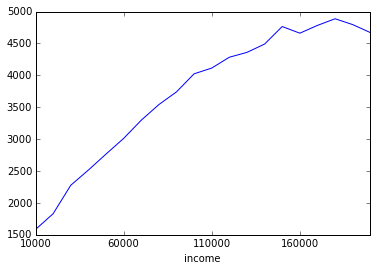

In [61]:
pd.options.display.float_format = '{:0,.2f}'.format
df['annual_cost'].plot()